In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
import commons
import utils
from data_utils import TextAudioLoader, TextAudioCollate, TextAudioSpeakerLoader, TextAudioSpeakerCollate
from models import SynthesizerTrn
from text.symbols import symbols
from text.symbols import phoneme_to_id
from text import text_to_sequence
import pyworld as pw
from scipy.io.wavfile import write
from scipy.interpolate import interp1d
def resize2d(source, target_len):
    source[source<0.001] = np.nan
    target = np.interp(np.linspace(0, len(source)-1, num=target_len,endpoint=True), np.arange(0, len(source)), source)
    return np.nan_to_num(target)
def _calculate_f0(input: np.ndarray,sr,length,f0min,f0max,
                      use_continuous_f0: bool=True,
                      use_log_f0: bool=True) -> np.ndarray:
        input = input.astype(float)
        frame_period = len(input)/sr/(length)*1000
        f0, timeaxis = pw.dio(
            input,
            fs=sr,
            f0_floor=f0min,
            f0_ceil=f0max,
            frame_period=frame_period)
        f0 = pw.stonemask(input, f0, timeaxis, sr)
        if use_continuous_f0:
            f0 = _convert_to_continuous_f0(f0)
        if use_log_f0:
            nonzero_idxs = np.where(f0 != 0)[0]
            f0[nonzero_idxs] = np.log(f0[nonzero_idxs])
        return f0.reshape(-1)
def get_text(text,transform=1.0,use_continuous_f0=True):
    hubert = torch.hub.load("bshall/hubert:main", f"hubert_soft")#.cuda()
    wav, sr = librosa.load(text,sr=None)
    
    assert(sr>15999)
    if len(wav.shape) > 1:
        wav = librosa.to_mono(wav)   
        
    wav16 = librosa.resample(wav, sr, 16000)
    print(wav16.shape)
    
    source = torch.FloatTensor(wav16).unsqueeze(0).unsqueeze(0)
    with torch.inference_mode():
        units = hubert.units(source)
    
    f0=_calculate_f0(wav,sr,units.shape[1],
            f0min=librosa.note_to_hz('C2'),
            f0max=librosa.note_to_hz('C7'),use_continuous_f0=use_continuous_f0)
    f0=resize2d(f0,units.shape[1])
    f0[f0!=0]=f0[f0!=0]+np.log(transform)
    #f0[:]=0
    f0 = torch.FloatTensor(f0).unsqueeze(-1).unsqueeze(0)

    output=torch.cat([units,f0,f0],dim=2)
    return output.squeeze()
def _convert_to_continuous_f0(f0: np.ndarray) -> np.ndarray:
    if (f0 == 0).all():
        print("All frames seems to be unvoiced.")
        return f0

    # padding start and end of f0 sequence
    start_f0 = f0[f0 != 0][0]
    end_f0 = f0[f0 != 0][-1]
    start_idx = np.where(f0 == start_f0)[0][0]
    end_idx = np.where(f0 == end_f0)[0][-1]
    f0[:start_idx] = start_f0
    f0[end_idx:] = end_f0

    # get non-zero frame index
    nonzero_idxs = np.where(f0 != 0)[0]

    # perform linear interpolation
    interp_fn = interp1d(nonzero_idxs, f0[nonzero_idxs])
    f0 = interp_fn(np.arange(0, f0.shape[0]))

    return f0
    
def getkey(key):
    return np.power(2,key/12.0)

def getmel(source,sr):
    mel_spectrogram = librosa.feature.melspectrogram(source, sr=sr, n_fft=1024, hop_length=512, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

e:\Codedata\anaconda\envs\cvcvits\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## AISHELL3

In [3]:
hps = utils.get_hparams_from_file("./configs/aishell_encode.json")

In [4]:
net_g = SynthesizerTrn(
    len(phoneme_to_id),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    n_speakers=hps.data.n_speakers,
    **hps.model)#.cuda()
_ = net_g.eval()

_ = utils.load_checkpoint("trained_model/G_328000.pth", net_g, None)

In [5]:
testaudio="122_90.wav"#"test0.wav"#"yyut.wav"#"2031.wav"#"tp0.wav"#"test3.wav"##"taffy2.wav"#"887_195.wav"#"2001_03.wav"#"mshj.wav"##"nyaru0.wav"#
stn_tst = get_text(testaudio,getkey(0),use_continuous_f0=False)
f0_tst=stn_tst[:,-1]
with torch.no_grad():
    x_tst = stn_tst.unsqueeze(0)#.cuda()
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)])#.cuda()
    sid = torch.LongTensor([0])#.cuda()
    #audio = net_g.infer(x_tst, x_tst_lengths, sid=sid, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
    audio = net_g.infer(x_tst, x_tst_lengths, sid=sid, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()


Using cache found in C:\Users\LED/.cache\torch\hub\bshall_hubert_main


(76802,)


In [6]:
demoaudio,sr=librosa.load(testaudio)
ipd.display(ipd.Audio(demoaudio, rate=sr))
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate, normalize=False))
import soundfile as sf
sf.write('stereo_file1.wav', audio, hps.data.sampling_rate, 'PCM_16')
f0_gen=get_text('stereo_file1.wav',use_continuous_f0=False)[:,-1]
#f0_gen=resize2d(f0_gen,len(f0_tst))

Using cache found in C:\Users\LED/.cache\torch\hub\bshall_hubert_main


(77277,)


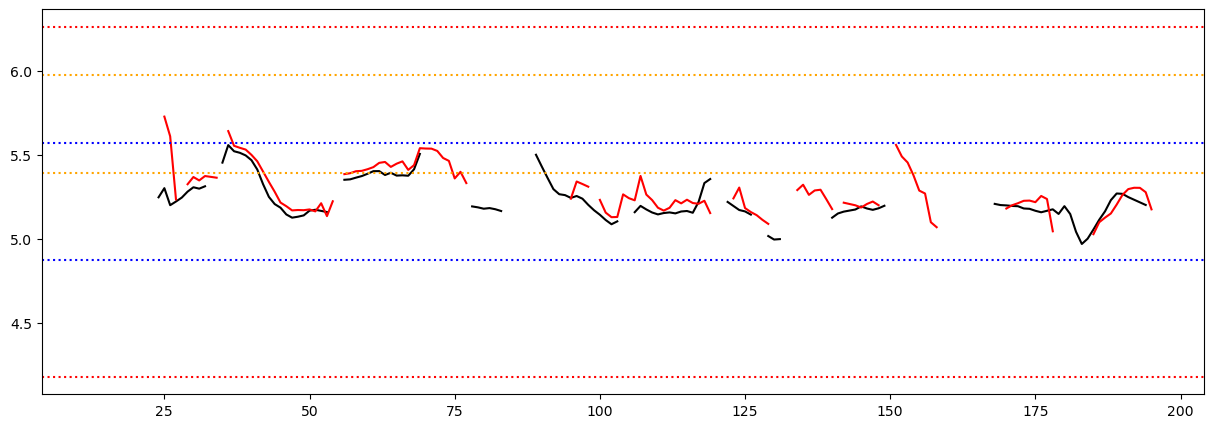

(128, 207)
(128, 209)


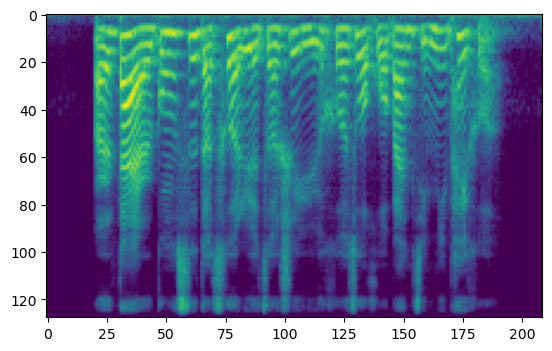

In [7]:
f0_tst[f0_tst==0]=np.nan
f0_gen[f0_gen==0]=np.nan
fig=plt.figure(figsize=[15,5])
plt.plot(np.arange(0,len(f0_tst)),f0_tst,color='black')
plt.plot(np.arange(0,len(f0_gen)),f0_gen,color='red')
plt.axhline(y=np.log(librosa.note_to_hz('C2')),ls=":",c="red")
plt.axhline(y=np.log(librosa.note_to_hz('C3')),ls=":",c="blue")
plt.axhline(y=np.log(librosa.note_to_hz('A3')),ls=":",c="orange")
plt.axhline(y=np.log(librosa.note_to_hz('C4')),ls=":",c="blue")
plt.axhline(y=np.log(librosa.note_to_hz('G4')),ls=":",c="orange")
plt.axhline(y=np.log(librosa.note_to_hz('C5')),ls=":",c="red")
plt.show()
# demomel=getmel(demoaudio,sr)
# mel=getmel(audio,22050)
# print(demomel.shape)
# print(mel.shape)
# plt.imshow(demomel)
# plt.imshow(mel)